In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit
from qiskit_aer.noise import NoiseModel, ReadoutError
from qiskit_aer import AerSimulator
from qiskit.result import sampled_expectation_value
from qiskit.quantum_info import SparsePauliOp

from qiskit.visualization import plot_histogram

from numpy.linalg import inv
from numpy import sqrt, dot, kron, array, diag

In [2]:
from numpy.random import default_rng
from numpy import pi
from qiskit.circuit import Parameter, ParameterVector


def build_qaoa_circuit(
        num_qubits: int, 
        depth: int, 
        *,
        measurements: bool = True, 
        barriers: bool = False, 
) -> QuantumCircuit:
    """Build parameterized QAOA quantum circuit.
    
    Args:
        num_qubits: number of qubits.
        depth: two-qubit depth (needs to be even).
        measurements: if True adds measurements at the end.
        barriers: if True adds barriers between layers.
    Returns:
        A dense QAOA quantum circuit for a linear, non-cyclic, graph
        with cost parameter-vector γ, and mixer parameter-vector β.
    """
    if num_qubits <= 2:
        raise ValueError("Number of qubits must be greater than two.")
    if depth % 2 != 0:
        raise ValueError("Depth must be even.")
    
    gammas = ParameterVector('γ', depth // 2) 
    betas = ParameterVector('β', depth // 2)

    circuit = QuantumCircuit(num_qubits)
    circuit.h(range(num_qubits))
    for layer in range(depth // 2):
        if barriers:
            circuit.barrier()
        for qubit in range(0, num_qubits - 1, 2):
            circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(1, num_qubits - 1, 2):
            circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(num_qubits):
            circuit.rx(betas[layer], qubit)
    
    if measurements:
        circuit.measure_all()
    return circuit


def produce_qaoa_parameters(num_layers, *, seed=None):
    """Produce random QAOA parameters.
    Args:
        num_layers: the number of QAOA layers.
        seed: a seed to generate the random angles.
    Returns:
        A tuple holding the beta and gamma angles.
    """
    rng = default_rng(seed=seed)
    betas = rng.uniform(-pi, pi, size=num_layers).tolist()
    gammas = rng.uniform(-pi, pi, size=num_layers).tolist()
    return betas, gammas


def build_compute_uncompute_qaoa_circuit(
        num_qubits: int, 
        depth: int, 
        *,
        measurements: bool = True, 
        barriers: bool = False, 
    ) -> QuantumCircuit:
    """Build a parametrized compute-uncompute QAOA quantum circuit."""
    if depth % 4 != 0:
       raise ValueError("Depth must be a multiple of four.")

    qaoa = build_qaoa_circuit(num_qubits, depth // 2, measurements=False, barriers=barriers)
    
    circuit = QuantumCircuit(num_qubits)
    circuit.compose(qaoa, inplace=True)
    circuit.barrier()
    circuit.compose(qaoa.inverse(), inplace=True)
    if measurements:
        circuit.measure_all(inplace=True)
    
    return circuit

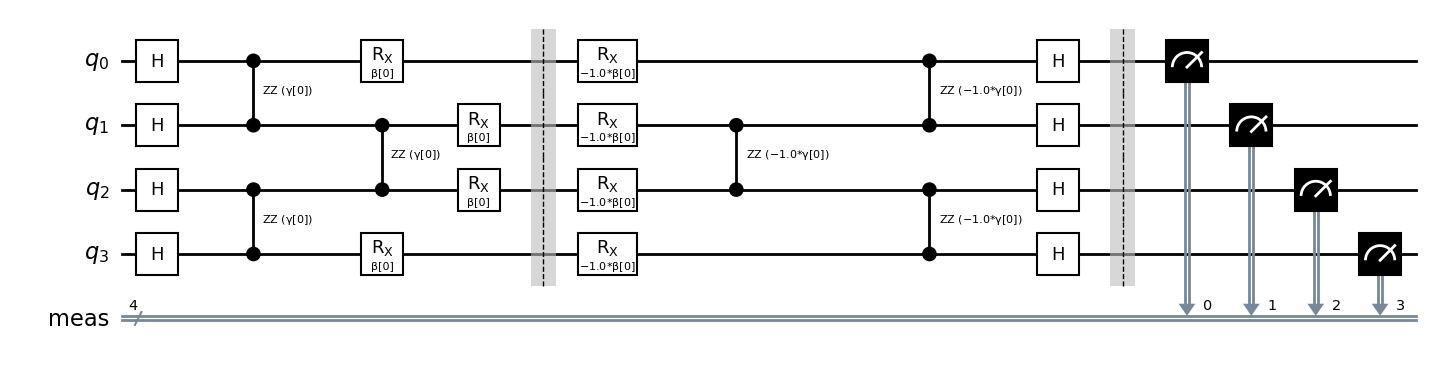

In [3]:
qc = build_compute_uncompute_qaoa_circuit(4,4)
qc.draw('mpl',style='bw',fold=-1)

In [4]:
betas, gammas = produce_qaoa_parameters(1)
params = [gammas[0], betas[0]]
params

[-0.9453364751036935, -2.895496617474788]

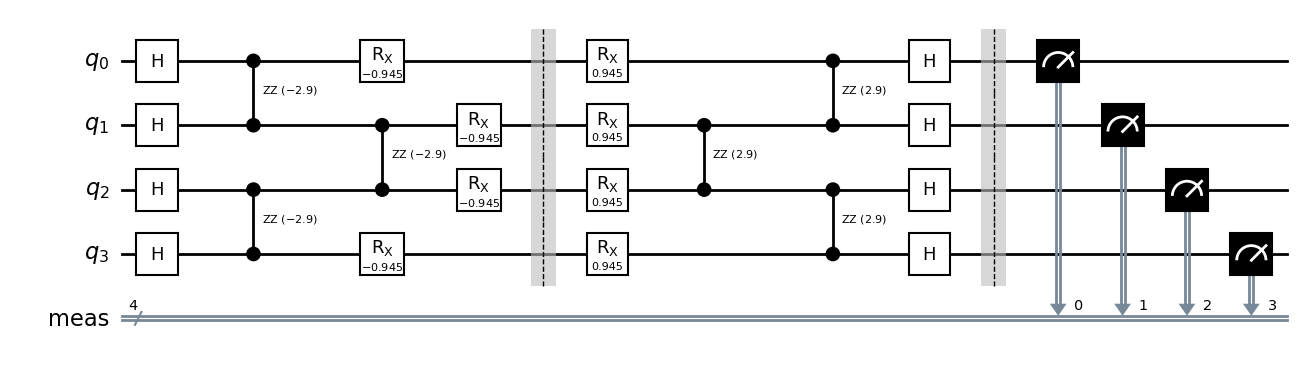

In [5]:
qc = qc.assign_parameters(params)
qc.draw('mpl',style='bw',fold=-1)

In [6]:
shots = 10000
observables = ['ZIII','IZII','IIZI','IIIZ','ZZII','IZZI','IIZZ','ZZZI','IZZZ','ZZZZ']

### First we create our noisy measurement

In [7]:
def create_measurement_error(p0g1: float, p1g0: float) -> NoiseModel:
    noise_model = NoiseModel()
    noise_model.add_all_qubit_readout_error([[1-p1g0,p1g0],[p0g1,1-p0g1]])
    return noise_model

In [8]:
noise_model = create_measurement_error(0.2,0.1)
simulator = AerSimulator(noise_model=noise_model)

#### Test the noise model

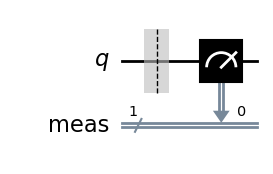

In [9]:
test = QuantumCircuit(1)
test.measure_all()
test.draw('mpl',style='bw')

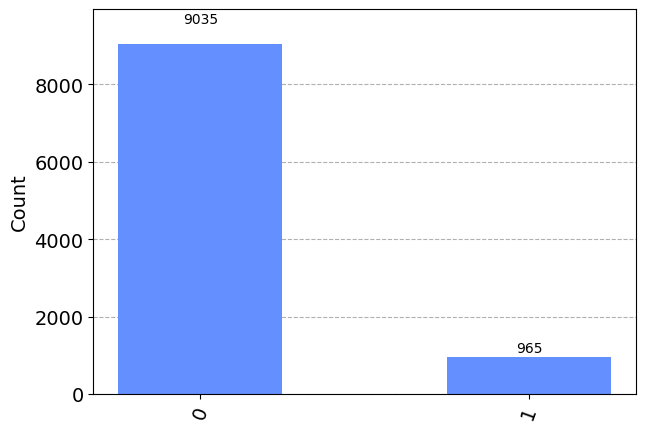

In [10]:
counts_test = simulator.run(test, shots=shots).result().get_counts()
plot_histogram(counts_test)

### Now we create the A matrix

In order to create the A matrix, we can run calibration experiments by preparing the qubit once in $|0\rangle$ and then in $|1\rangle$.

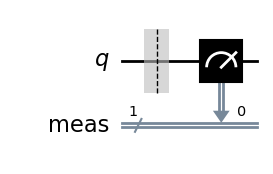

In [11]:
cal0 = QuantumCircuit(1)
cal0.measure_all()
cal0.draw('mpl',style='bw')

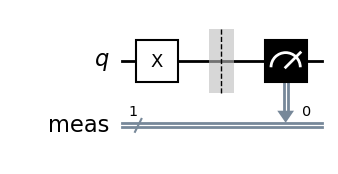

In [12]:
cal1 = QuantumCircuit(1)
cal1.x(0)
cal1.measure_all()
cal1.draw('mpl',style='bw')

In [13]:
counts = simulator.run([cal0,cal1],shots=shots).result().get_counts()
counts

[{'1': 954, '0': 9046}, {'0': 2035, '1': 7965}]

In [14]:
for count_dict in counts:
    count_dict['0'] = count_dict['0']/shots
    count_dict['1'] = count_dict['1']/shots

counts

[{'1': 0.0954, '0': 0.9046}, {'0': 0.2035, '1': 0.7965}]

In [15]:
A_1q = [[counts[0]['0'], counts[1]['0']], [counts[0]['1'], counts[1]['1']]]
A_1q

[[0.9046, 0.2035], [0.0954, 0.7965]]

### Obtain the ideal and noisy expectation values

#### Ideal expectation value

In [16]:
counts_ideal = AerSimulator().run(qc,shots=shots).result().get_counts()

for key, val in counts_ideal.items():
    counts_ideal[key] = val/shots
    
counts_ideal

{'0000': 1.0}

In [17]:
ideal_expval = {}

for obs in observables:
    expval = sampled_expectation_value(counts_ideal, SparsePauliOp(obs))
    ideal_expval[obs] = expval

ideal_expval

{'ZIII': 1.0,
 'IZII': 1.0,
 'IIZI': 1.0,
 'IIIZ': 1.0,
 'ZZII': 1.0,
 'IZZI': 1.0,
 'IIZZ': 1.0,
 'ZZZI': 1.0,
 'IZZZ': 1.0,
 'ZZZZ': 1.0}

#### Noisy expectation value

In [18]:
counts_noisy = simulator.run(qc,shots=shots).result().get_counts()

for key, val in counts_noisy.items():
    counts_noisy[key] = val/shots
    
counts_noisy

{'1101': 0.0007,
 '1110': 0.0012,
 '0010': 0.0766,
 '0000': 0.6545,
 '1100': 0.0078,
 '0111': 0.001,
 '0011': 0.008,
 '1011': 0.0014,
 '1010': 0.0088,
 '0100': 0.0732,
 '0001': 0.0732,
 '1000': 0.0702,
 '0110': 0.0089,
 '1001': 0.0075,
 '0101': 0.007}

In [19]:
noisy_expval = {}

for obs in observables:
    expval = sampled_expectation_value(counts_noisy, SparsePauliOp(obs))
    noisy_expval[obs] = expval

noisy_expval

{'ZIII': 0.8048,
 'IZII': 0.8003999999999998,
 'IIZI': 0.7882,
 'IIIZ': 0.8024000000000001,
 'ZZII': 0.644,
 'IZZI': 0.6329999999999999,
 'IIZZ': 0.6321999999999999,
 'ZZZI': 0.5126,
 'IZZZ': 0.5037999999999999,
 'ZZZZ': 0.4050000000000001}

### Invert the A matrix and perform mitigation

First we need to build the full A matrix: $A = A_{n-1} \otimes A_{n-2} \otimes ... \otimes A_0$

In [20]:
A = kron(A_1q,kron(A_1q,kron(A_1q,A_1q)))
A

array([[6.69616788e-01, 1.50637869e-01, 1.50637869e-01, 3.38876922e-02,
        1.50637869e-01, 3.38876922e-02, 3.38876922e-02, 7.62341959e-03,
        1.50637869e-01, 3.38876922e-02, 3.38876922e-02, 7.62341959e-03,
        3.38876922e-02, 7.62341959e-03, 7.62341959e-03, 1.71497445e-03],
       [7.06184409e-02, 5.89597360e-01, 1.58864169e-02, 1.32636594e-01,
        1.58864169e-02, 1.32636594e-01, 3.57382914e-03, 2.98381018e-02,
        1.58864169e-02, 1.32636594e-01, 3.57382914e-03, 2.98381018e-02,
        3.57382914e-03, 2.98381018e-02, 8.03973280e-04, 6.71241842e-03],
       [7.06184409e-02, 1.58864169e-02, 5.89597360e-01, 1.32636594e-01,
        1.58864169e-02, 3.57382914e-03, 1.32636594e-01, 2.98381018e-02,
        1.58864169e-02, 3.57382914e-03, 1.32636594e-01, 2.98381018e-02,
        3.57382914e-03, 8.03973280e-04, 2.98381018e-02, 6.71241842e-03],
       [7.44748979e-03, 6.21795138e-02, 6.21795138e-02, 5.19140280e-01,
        1.67539705e-03, 1.39879848e-02, 1.39879848e-02, 1.167

In [21]:
diag(A)

array([0.66961679, 0.58959736, 0.58959736, 0.51914028, 0.58959736,
       0.51914028, 0.51914028, 0.45710284, 0.58959736, 0.51914028,
       0.51914028, 0.45710284, 0.51914028, 0.45710284, 0.45710284,
       0.4024789 ])

In [22]:
A_inv = inv(A)
A_inv

array([[ 1.66580151e+00, -4.25600261e-01, -4.25600261e-01,
         1.08737794e-01, -4.25600261e-01,  1.08737794e-01,
         1.08737794e-01, -2.77817214e-02, -4.25600261e-01,
         1.08737794e-01,  1.08737794e-01, -2.77817214e-02,
         1.08737794e-01, -2.77817214e-02, -2.77817214e-02,
         7.09802927e-03],
       [-1.99519729e-01,  1.89188204e+00,  5.09758505e-02,
        -4.83362205e-01,  5.09758505e-02, -4.83362205e-01,
        -1.30239618e-02,  1.23495554e-01,  5.09758505e-02,
        -4.83362205e-01, -1.30239618e-02,  1.23495554e-01,
        -1.30239618e-02,  1.23495554e-01,  3.32752822e-03,
        -3.15522225e-02],
       [-1.99519729e-01,  5.09758505e-02,  1.89188204e+00,
        -4.83362205e-01,  5.09758505e-02, -1.30239618e-02,
        -4.83362205e-01,  1.23495554e-01,  5.09758505e-02,
        -1.30239618e-02, -4.83362205e-01,  1.23495554e-01,
        -1.30239618e-02,  3.32752822e-03,  1.23495554e-01,
        -3.15522225e-02],
       [ 2.38972783e-02, -2.26598301e

In [25]:
diag(A_inv)

array([1.68589204, 1.89941872, 1.89941872, 2.13998961, 1.89941872,
       2.13998961, 2.13998961, 2.41103001, 1.89941872, 2.13998961,
       2.13998961, 2.41103001, 2.13998961, 2.41103001, 2.41103001,
       2.71639904])

In [26]:
list_counts_noisy = array([counts_noisy[key] for key in sorted(list(counts_noisy.keys()))])

mitigated_counts_list = dot(A_inv, list_counts_noisy)
mitigated_counts_list

array([ 9.66597290e-01,  1.29105825e-02,  1.26801006e-02, -2.90061344e-03,
        1.37647728e-02, -3.13581184e-03, -3.91637681e-03,  2.99514930e-04,
        5.63608102e-03, -1.73488627e-03, -2.87137214e-04,  6.93800170e-04,
       -1.53520562e-03, -4.73218682e-04,  1.22500652e-03,  1.76100919e-04])

In [27]:
mitigated_counts = {}

for idx, key in enumerate(sorted(list(counts_noisy.keys()))):
    mitigated_counts[key] = mitigated_counts_list[idx]
    
mitigated_counts

{'0000': 0.9665972904252587,
 '0001': 0.012910582473247972,
 '0010': 0.012680100600620529,
 '0011': -0.0029006134443384374,
 '0100': 0.013764772815557921,
 '0101': -0.003135811837144449,
 '0110': -0.0039163768110515845,
 '0111': 0.000299514929571269,
 '1000': 0.005636081019128126,
 '1001': -0.0017348862677228167,
 '1010': -0.00028713721400420685,
 '1011': 0.000693800170405944,
 '1100': -0.0015352056193673799,
 '1101': -0.00047321868217216573,
 '1110': 0.001225006523111754,
 '1111': 0.0001761009188985252}

In [28]:
sum(list(mitigated_counts.values()))

0.9999999999999993

In [29]:
mitigated_expval = {}

for obs in observables:
    expval = sampled_expectation_value(mitigated_counts, SparsePauliOp(obs))
    mitigated_expval[obs] = expval

mitigated_expval

{'ZIII': 0.9925989183034444,
 'IZII': 0.9871904355251926,
 'IIZI': 0.9840592086535724,
 'IIIZ': 0.9883290634785084,
 'ZZII': 0.9773600863905195,
 'IZZI': 0.9623866264208846,
 'IIZZ': 0.9654634824302301,
 'ZZZI': 0.9485784993437777,
 'IZZZ': 0.9274523147263966,
 'ZZZZ': 0.9065267203010574}

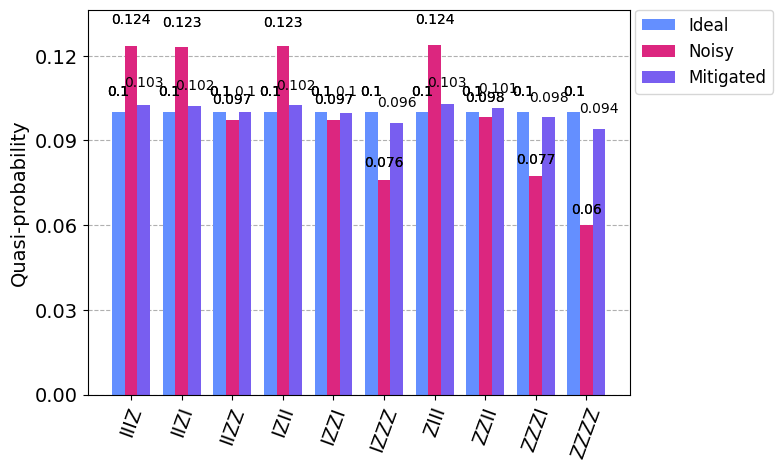

In [30]:
plot_histogram([ideal_expval, noisy_expval, mitigated_expval], legend=['Ideal','Noisy','Mitigated'])